# About 

In this notebook, we will inspect the visual outcomes of [Spatio-Temporal Modulator](https://github.com/innat/Video-FocalNets/blob/8017a9a9706af030a1829df19868de7608a12907/videofocalnet/layers/spatio_temporal_focal_modulation.py#L6) layer, same as shown in the [official source](https://github.com/TalalWasim/Video-FocalNets#visualization-first-and-last-layer-spatio-temporal-modulator). We will use **GradCAM** technique to interpret the layer. 

In [1]:
!pip install decord gdown -q

In [2]:
import os, warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from decord import VideoReader
from huggingface_hub import hf_hub_download
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
from tensorflow import keras

**utils**

In [3]:
def denormalize(z):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.225, 0.225, 0.225])
    x = (z * std) + mean
    x = x * 255
    return x.clip(0, 255)

def show_sequence(seq, sample=8, title=''):
    '''Plot a sequence of images horizontally'''
    # clip is [T, H, W, 3]
    fig = plt.figure(figsize=(20, 2.5))
    fig.suptitle(title, fontsize=16)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, sample), axes_pad=0.1)
    for ax, img in zip(grid, seq):
        ax.imshow(img)
        ax.set_axis_off()
    plt.show()
    return

**sample data process**

In [70]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

def read_video(file_path):
    vr = VideoReader(file_path)
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(
        frames,
        output_size=(224, 224)
    )

def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.uint8)
    frame = tf.image.resize(frame, size=list(output_size))
    frame = frame / 255.
    frame = frame - IMAGENET_MEAN
    frame = frame / IMAGENET_STD
    return frame

def uniform_temporal_subsample(
    x, num_samples, clip_idx, total_clips, frame_rate=1, temporal_dim=-4
):
    t = tf.shape(x)[temporal_dim]
    max_offset = t - num_samples * frame_rate
    step = max_offset // total_clips
    offset = clip_idx * step
    indices = tf.linspace(
        tf.cast(offset, tf.float32),
        tf.cast(offset + (num_samples-1) * frame_rate, tf.float32),
        num_samples
    )
    indices = tf.clip_by_value(indices, 0, tf.cast(t - 1, tf.float32))
    indices = tf.cast(tf.round(indices), tf.int32)
    return tf.gather(x, indices, axis=temporal_dim)


def clip_generator(
    image, num_frames=32, frame_rate=1, num_clips=1, crop_size=224
):
    clips_list = []
    for i in range(num_clips):
        frame = uniform_temporal_subsample(
            image, num_frames, i, num_clips, frame_rate=frame_rate, temporal_dim=0
        )
        clips_list.append(frame)

    video = tf.stack(clips_list)
    video = tf.reshape(
        video, [num_clips*num_frames, crop_size, crop_size, 3]
    )
    return video


num_frame=8
sampling_rate=16
mp4file='./kinetics/test/opening_bottle/2EPtfi-GFSw.mp4'
sequence=read_video(mp4file)
frames=clip_generator(sequence, num_frame, sampling_rate, num_clips=1)
frames.shape

TensorShape([8, 224, 224, 3])

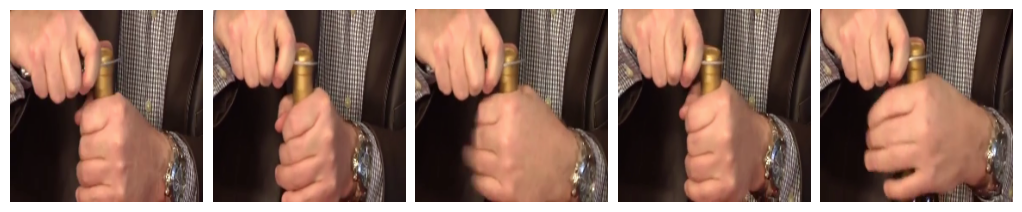

In [71]:
show_sequence(
    denormalize(frames.numpy()).astype('uint8'), sample=5
)

# Video FocalNet

In a model, the total number of [`SpatioTemporalFocalModulation`](https://github.com/innat/Video-FocalNets/blob/8017a9a9706af030a1829df19868de7608a12907/videofocalnet/layers/spatio_temporal_focal_modulation.py#L6) layer is invoked as the sum of [`depths`](https://github.com/innat/Video-FocalNets/blob/8017a9a9706af030a1829df19868de7608a12907/videofocalnet/model_configs.py#L28) of the model.



In [9]:
from videofocalnet import VideoFocalNetB

model_name = 'FocalNetB_K400'  
vfocal_net = VideoFocalNetB(name=model_name)
_ = vfocal_net(tf.ones(shape=(1, 8, 224, 224, 3)))

vfocal_net.load_weights('TFVideoFocalNetB_K400_8x224.h5')
vfocal_net.summary(line_length=70)

Model: "FocalNetB_K400"
______________________________________________________________________
 Layer (type)                  Output Shape                Param #    
 TFPatchEmbed (TFPatchEmbed)   multiple                    6528       
                                                                      
 dropout (Dropout)             multiple                    0          
                                                                      
 TFBasicLayer1 (TFBasicLayer)  multiple                    866828     
                                                                      
 TFBasicLayer2 (TFBasicLayer)  multiple                    3437580    
                                                                      
 TFBasicLayer3 (TFBasicLayer)  multiple                    106416236  
                                                                      
 TFBasicLayer4 (TFBasicLayer)  multiple                    46249996   
                                                     

To get the tensor output of `SpatioTemporalFocalModulation` from all blocks, we will pass `return_stfm=True` as follows. The `stfm` refers as spatio-temporal focal modulator.

In [10]:
y_pred, sp_modulator_dicts = vfocal_net(
    frames[None, ...], training=False, return_stfm=True
)
y_pred.shape

TensorShape([1, 400])

In [11]:
for k, v in sp_modulator_dicts.items():
    print(k, v.shape)

TFVideoFocalNetBlock_id11 (8, 56, 56, 128)
TFVideoFocalNetBlock_id12 (8, 56, 56, 128)
TFVideoFocalNetBlock_id21 (8, 28, 28, 256)
TFVideoFocalNetBlock_id22 (8, 28, 28, 256)
TFVideoFocalNetBlock_id31 (8, 14, 14, 512)
TFVideoFocalNetBlock_id32 (8, 14, 14, 512)
TFVideoFocalNetBlock_id33 (8, 14, 14, 512)
TFVideoFocalNetBlock_id34 (8, 14, 14, 512)
TFVideoFocalNetBlock_id35 (8, 14, 14, 512)
TFVideoFocalNetBlock_id36 (8, 14, 14, 512)
TFVideoFocalNetBlock_id37 (8, 14, 14, 512)
TFVideoFocalNetBlock_id38 (8, 14, 14, 512)
TFVideoFocalNetBlock_id39 (8, 14, 14, 512)
TFVideoFocalNetBlock_id310 (8, 14, 14, 512)
TFVideoFocalNetBlock_id311 (8, 14, 14, 512)
TFVideoFocalNetBlock_id312 (8, 14, 14, 512)
TFVideoFocalNetBlock_id313 (8, 14, 14, 512)
TFVideoFocalNetBlock_id314 (8, 14, 14, 512)
TFVideoFocalNetBlock_id315 (8, 14, 14, 512)
TFVideoFocalNetBlock_id316 (8, 14, 14, 512)
TFVideoFocalNetBlock_id317 (8, 14, 14, 512)
TFVideoFocalNetBlock_id318 (8, 14, 14, 512)
TFVideoFocalNetBlock_id41 (8, 7, 7, 1024)
TFV

Same as official way, let's select the first and last part of `SpatioTemporalFocalModulation` module.

In [12]:
first_stfm_layer = 'TFVideoFocalNetBlock_id11'
last_stfm_layer  = 'TFVideoFocalNetBlock_id42'

**grad-cam**

In [13]:
def grad_cam(model, target_layer):
    with tf.GradientTape() as tape:
        y_pred_tf, sp_modulator_dicts = model(
            frames[None, ...], training=False, return_stfm=True
        )
        pred_index = tf.argmax(y_pred_tf[0])
        class_channel = y_pred_tf[:, pred_index]
    
    grads = tape.gradient(class_channel, sp_modulator_dicts[target_layer])
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    heatmap_frame = []
    for each_frame in sp_modulator_dicts[target_layer]:
        heatmap = each_frame @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmap_frame.append(heatmap.numpy())
    heatmap_frame = np.stack(heatmap_frame, axis=0)
    return heatmap_frame

In [20]:
def overlap(heatmaps, inputs):
    overlap_frames = []
    
    def __overlap(heatmap_array, input_array, alpha=0.7):
        heatmap = np.uint8(255 * heatmap_array)
        jet = cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((input_array.shape[1], input_array.shape[0]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap)

        superimposed_img = jet_heatmap * alpha + input_array
        superimposed_img = keras.utils.array_to_img(superimposed_img)
        return superimposed_img
    
    for x, y in zip((heatmaps), inputs):
        out = __overlap(x, y)
        overlap_frames.append(out)

    overlap_frames = np.stack(overlap_frames, axis=0)
    return overlap_frames

**raw frames**

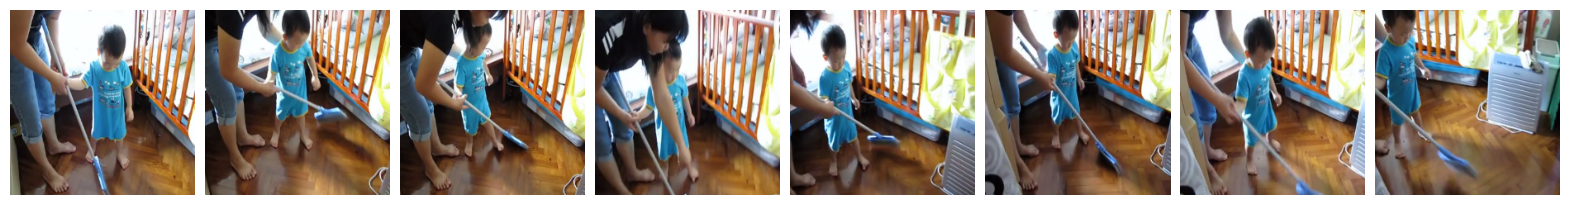

In [15]:
show_sequence(
    denormalize(frames.numpy()).astype('uint8'), sample=len(frames.numpy())
)

**heatmaps**

In [72]:
first_heatmap_frame = grad_cam(vfocal_net, target_layer=first_stfm_layer)
last_heatmap_frame = grad_cam(vfocal_net, target_layer=last_stfm_layer)
first_heatmap_frame.shape, last_heatmap_frame.shape

((8, 56, 56), (8, 7, 7))

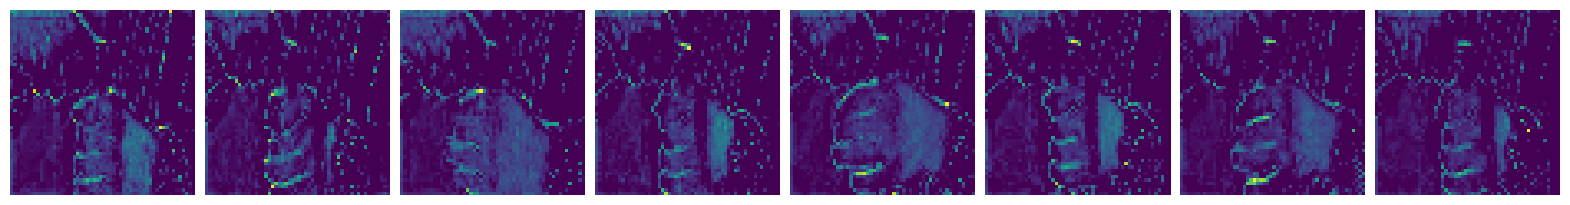

In [73]:
show_sequence(first_heatmap_frame, sample=len(first_heatmap_frame))

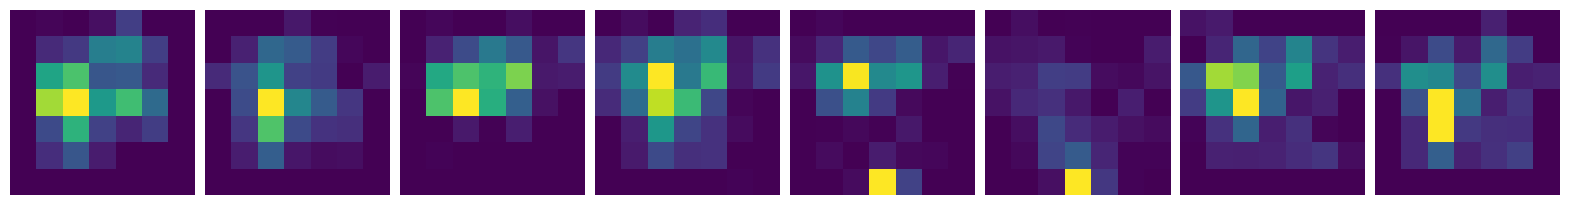

In [74]:
show_sequence(last_heatmap_frame, sample=len(last_heatmap_frame))

**overlaps**

In [75]:
first_overlap_frames = overlap(first_heatmap_frame, denormalize(frames.numpy()))
last_overlap_frames = overlap(last_heatmap_frame, denormalize(frames.numpy()))
first_overlap_frames.shape, last_overlap_frames.shape

((8, 224, 224, 3), (8, 224, 224, 3))

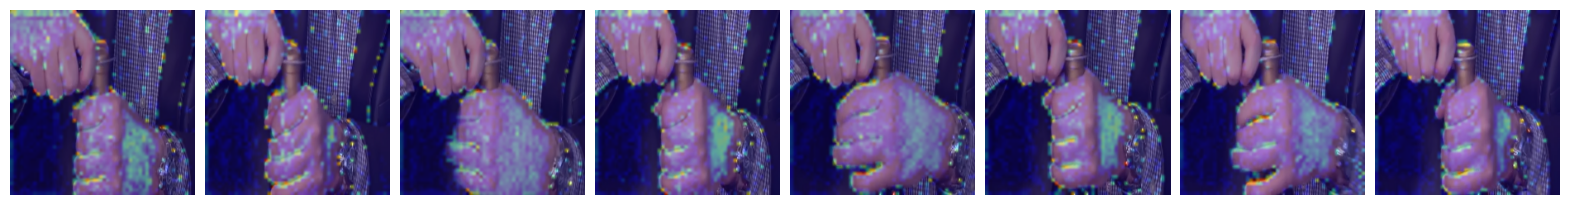

In [76]:
show_sequence(first_overlap_frames, sample=len(first_overlap_frames))

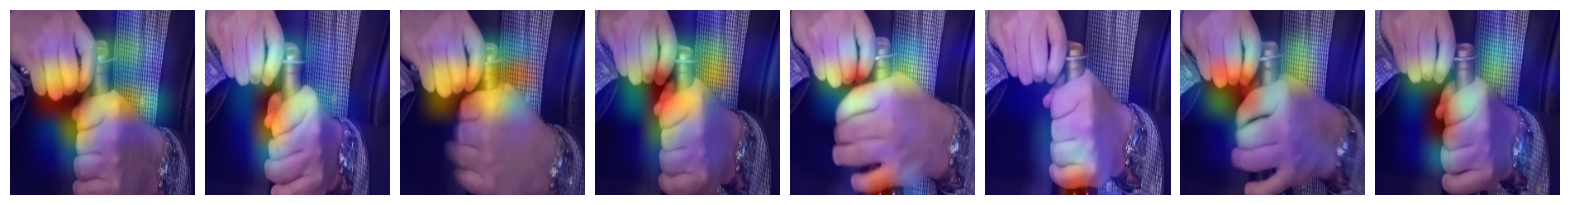

In [77]:
show_sequence(last_overlap_frames, sample=len(last_overlap_frames))